## Imports and downloads

In [1]:
!pip install pandarallel

  Preparing metadata (setup.py) ... - done
  Created wheel for pandarallel: filename=pandarallel-1.6.5-py3-none-any.whl size=16672 sha256=6be3f0c0601b83ae273485226a35c3981c094a5cf3735cc5691e1e8884297eea
  Stored in directory: /root/.cache/pip/wheels/50/4f/1e/34e057bb868842209f1623f195b74fd7eda229308a7352d47f
Successfully built pandarallel


In [2]:
import numpy as np 
import pandas as pd 
import seaborn as sns
from pandarallel import pandarallel
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('punkt')
from wordcloud import WordCloud
import plotly.graph_objs as go
import re
import plotly.io as pio
from collections import Counter

import subprocess

# Download and unzip wordnet
try:
    nltk.data.find('wordnet.zip')
except:
    nltk.download('wordnet', download_dir='/kaggle/working/')
    command = "unzip /kaggle/working/corpora/wordnet.zip -d /kaggle/working/corpora"
    subprocess.run(command.split())
    nltk.data.path.append('/kaggle/working/')
    
print('Imports done.')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /kaggle/working/...
Archive:  /kaggle/working/corpora/wordnet.zip
   creating: /kaggle/working/corpora/wordnet/
  inflating: /kaggle/working/corpora/wordnet/lexnames  
  inflating: /kaggle/working/corpora/wordnet/data.verb  
  inflating: /kaggle/working/corpora/wordnet/index.adv  
  inflating: /kaggle/working/corpora/wordnet/adv.exc  
  inflating: /kaggle/working/corpora/wordnet/index.verb  
  inflating: /kaggle/working/corpora/wordnet/cntlist.rev  
  inflating: /kaggle/working/corpora/wordnet/data.adj  
  inflating: /kaggle/working/corpora/wordnet/index.adj  
  inflating: /kaggle/working/corpora/wordnet/LICENSE  
  inflating: /kaggle/working/corpora/wordnet/citation.bib  
  inflating: /kaggle/working/corpor

## Data pre-processing

In [3]:
electronics_dataset = pd.read_csv('../input/amazon-reviews-2018-electronics/labeled_electronics_dataset.csv')

electronics_dataset.head()

,overall,vote,reviewTime,reviewText,summary,Label
0,2,0,2010-02-10,Tech support is the worst,1265760000,NEGATIVE
1,2,0,2016-10-24,Screws were missing from the bracket and beaut...,Spend a little more and get much better.,NEGATIVE
2,1,0,2017-07-10,Trouble connecting and staying connected via b...,1499644800,NEGATIVE
3,4,5,2013-05-02,I purchased this unit for our RV to replace an...,Receiver Offers a Lot of Flexibility & Complexity,POSITIVE
4,3,0,2013-01-04,It works. Nuff said but the review requires 1...,It's a cable,NEUTRAL


In [4]:
# Check for NaN values
print("NaN (before cleanup) ?: \n", electronics_dataset.isnull().sum())

electronics_dataset['reviewText'] = electronics_dataset['reviewText'].fillna('')

print("NaN (after cleanup) ?: \n", electronics_dataset.isnull().sum())

NaN (before cleanup) ?: 
 overall       0
vote          0
reviewTime    0
reviewText    1
summary       0
Label         0
dtype: int64
NaN (after cleanup) ?: 
 overall       0
vote          0
reviewTime    0
reviewText    0
summary       0
Label         0
dtype: int64


In [5]:
# Text preprocessing for reviewText column
# Lower all text

electronics_dataset['reviewText'] = electronics_dataset['reviewText'].str.lower()

# Initialize pandarallel
# I used pandarallel because it applies the functions much faster than a normal pandas apply.
pandarallel.initialize(nb_workers=4,progress_bar=True)

# Remove all special characters
def remove_special_chars(text):
    return ''.join(x if x.isalnum() else ' ' for x in text)

electronics_dataset['reviewText'] = electronics_dataset['reviewText'].parallel_apply(remove_special_chars)

# get stopwords.
stop_words = set(stopwords.words('english'))

# Remove stop_words
def remove_stopwords(text):
    words = word_tokenize(text)
    return [x for x in words if x not in stop_words]


electronics_dataset['reviewText'] = electronics_dataset['reviewText'].parallel_apply(remove_stopwords)

# Lemmatization
def lemmatize_word(text):
    wordnet = WordNetLemmatizer()
    return " ".join([wordnet.lemmatize(word) for word in text])

electronics_dataset['reviewText'] = electronics_dataset['reviewText'].parallel_apply(lemmatize_word)

# Remove numbers
def remove_numbers(text):
    return re.sub(r'\d+', '', text)

electronics_dataset['reviewText'] = electronics_dataset['reviewText'].parallel_apply(remove_numbers)

print('Example of preprocessing train: ')
print(electronics_dataset['reviewText'][0])

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


Example of preprocessing train: 
tech support worst


## Visualizations

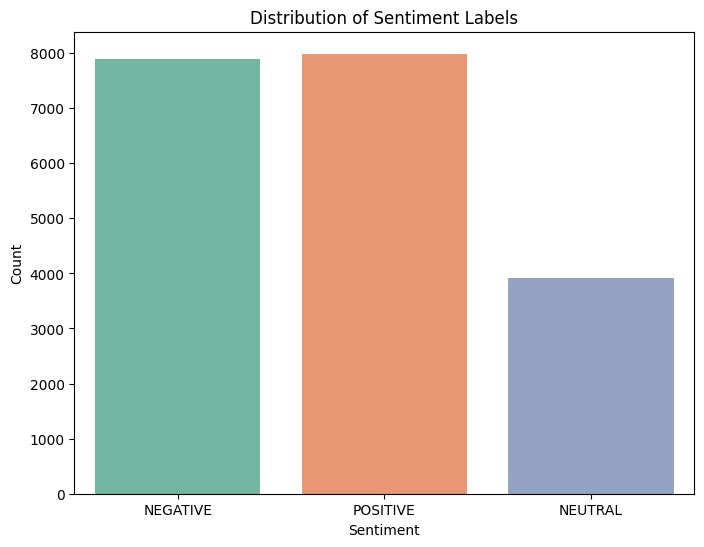

In [6]:
# Distribution plot
plt.figure(figsize=(8, 6))
sns.countplot(x='Label', data=electronics_dataset, palette='Set2')

# Adding labels and title
plt.title('Distribution of Sentiment Labels')
plt.xlabel('Sentiment')
plt.ylabel('Count')

# Show the plot
plt.show()

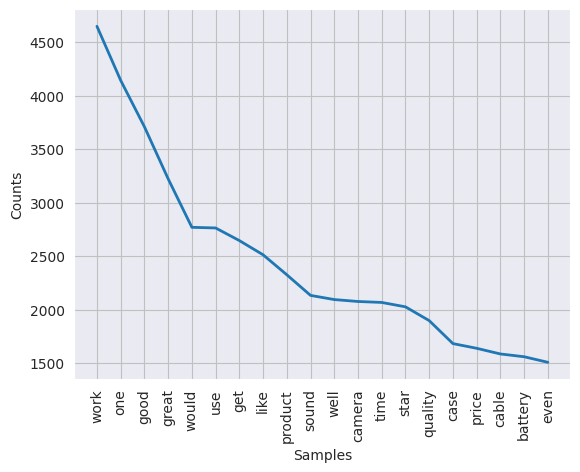

In [7]:
# Tokens frequency diagram
all_text = ' '.join(electronics_dataset['reviewText'])
tokens = word_tokenize(all_text)

sns.set_style('darkgrid')
nlp_words=nltk.FreqDist(tokens)
nlp_words.plot(20);

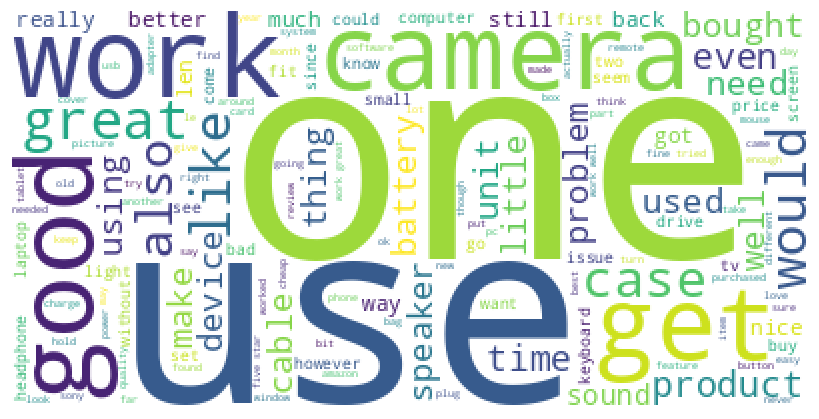

In [8]:
# Word cloud
all_text = ' '.join(tokens)
wordcloud = WordCloud(stopwords=stop_words, background_color='white').generate(all_text)
 
# plot the WordCloud image                       
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

In [9]:
# Ratings variation
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

histogram_trace = go.Histogram(x=electronics_dataset['overall'], 
                               xbins=dict(start=0.5, end=5.5, size=1),
                               marker=dict(color=colors),
                               opacity=0.75)

# Create the layout
layout = go.Layout(title='Review Rating Distribution',
                   xaxis=dict(title='Rating'),
                   yaxis=dict(title='Count'),
                   bargap=0.1)

# Create the figure
fig = go.Figure(data=[histogram_trace], layout=layout)

# Display the figure
pio.show(fig)

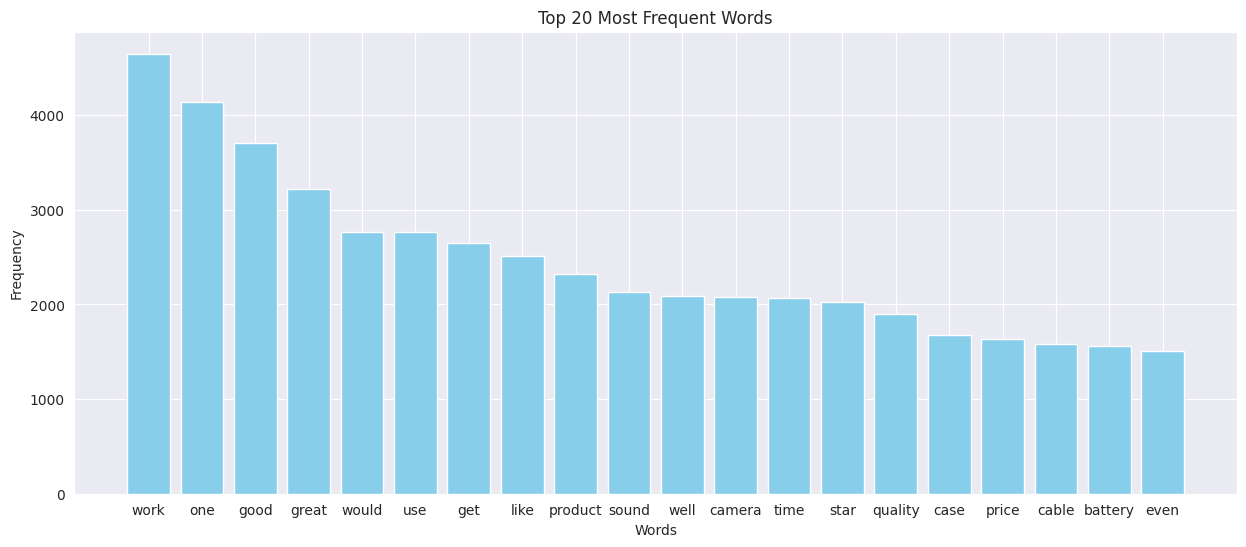

In [10]:
# Frequency bar chart
# Count the frequency of each word in the corpus
word_freq = Counter(tokens)

# Number of top words to display
top_n = 20

# Extract the top N most frequent words and their frequencies
top_words = [word for word, _ in word_freq.most_common(top_n)]
word_counts = [count for _, count in word_freq.most_common(top_n)]

# Create bar chart
plt.figure(figsize=(15, 6))
plt.bar(top_words, word_counts, color='skyblue')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title(f'Top {top_n} Most Frequent Words')
plt.show()

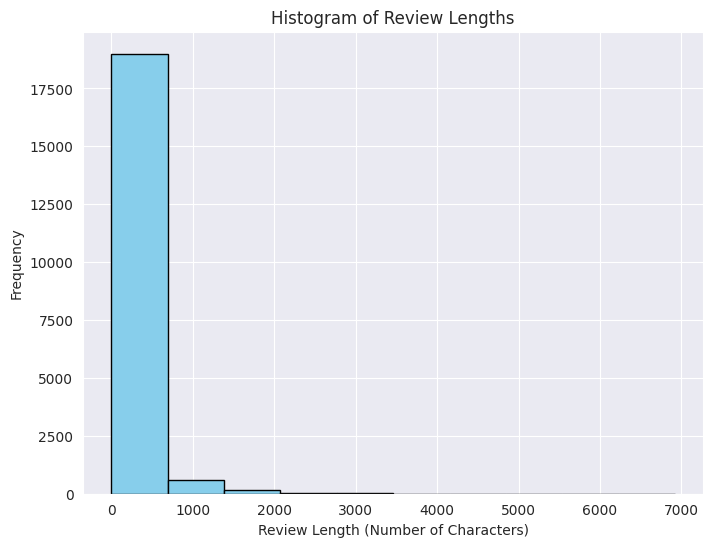

In [11]:
# Distribution of review lengths
# Calculate review lengths (number of characters)
review_lengths = [len(review) for review in electronics_dataset['reviewText']]

# Create histogram
plt.figure(figsize=(8, 6))
plt.hist(review_lengths, bins=10, color='skyblue', edgecolor='black')
plt.xlabel('Review Length (Number of Characters)')
plt.ylabel('Frequency')
plt.title('Histogram of Review Lengths')
plt.grid(True)
plt.show()